# Introduction
In the last tutorial notebook, I described the conventional approach for analyzing time-varying properties of neural oscillations, and in this notebook, we will go over our alternative approach. The fundamental goal of this approach is to characterize neural oscillations directly in the time domain. However, this is not straightforward because it attempts to extract the properties of the oscillatory component, despite the large amount of noise. Specifically, there are two very difficult problems:
1. What are the features of the oscillation? How do they vary over time?
2. During what times is the oscillation present?

The cycle-by-cycle approach deploys a few strategies to approach these questions. As its name indicates, this algorithm segments the signal into individual cycles and then analyzes their features separately from one another. Normally, some preprocessing is recommended to aid in localizing peaks and troughs (eliminating high frequency power that mostly do not comprise the oscillator of interest). Additionally, a burst detection approach is applied to define the segments of the signal to be analyzed for their oscillatory properties.

During this process (as with all data analyses), it is important to be aware if the data is being processed appropriately. As signal processing is complicated, it is very beneficial to visualize the measured features along with the raw data to assure they make sense.

# 0. Preprocess signal
A crucial part of the cycle-by-cycle approach is the ability to localize the peaks and troughs of the oscillation. Therefore, some preprocessing of the signal is often useful in order to make these extrema more apparent, i.e. isolate the oscillation component and minimize the nonoscillatory components. One effective way of doing this is by applying a lowpass filter. The choice of cutoff frequency is very important. The cutoff frequency should not be low enough in order to remove high frequency "noise" that interferes with extrema localization but not so low that it deforms the shape of the oscillation of interest. In order to assess this, the user should plot the filtered signal in comparison to the original signal.

(2, 5)

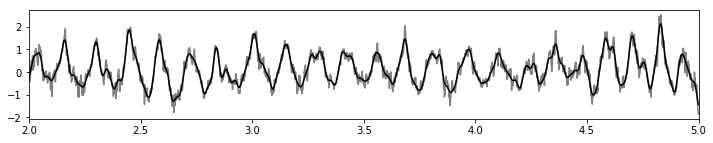

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from bycycle.filt import lowpass_filter
%matplotlib inline

signal = np.load('data/ca1.npy') / 1000
signal = signal[:125000]
Fs = 1250
f_theta = (4, 10)
f_lowpass = 30
N_seconds = .1

signal_low = lowpass_filter(signal, Fs, f_lowpass,
                            N_seconds=N_seconds, remove_edge_artifacts=False)


# Plot signal
t = np.arange(0, len(signal)/Fs, 1/Fs)
tlim = (2, 5)
tidx = np.logical_and(t>=tlim[0], t<tlim[1])

plt.figure(figsize=(12, 2))
plt.plot(t[tidx], signal[tidx], '.5')
plt.plot(t[tidx], signal_low[tidx], 'k')
plt.xlim(tlim)

# 1. Localize peaks and troughs
In order to characterize the oscillation, it is useful to know the precise times of peaks and troughs. For one, this will allow us to compute the periods and rise-decay symmetries of the individual cycles. To do this, the signal is first narrow-bandpass filtered in order to estimate "zero-crossings." Then, in between these zerocrossings, the absolute maxima and minima are found and labeled as the peaks and troughs, respectively.

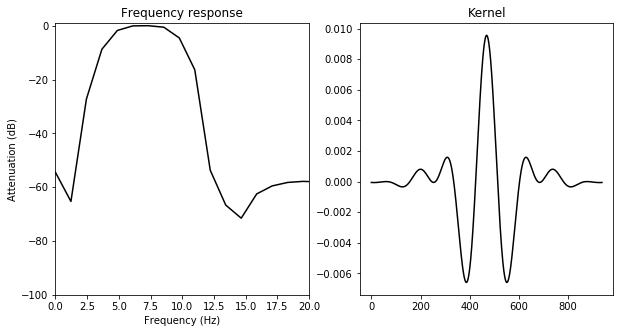

array([nan, nan, nan, ..., nan, nan, nan])

In [2]:
# Plot frequency response of bandpass filter
from bycycle.filt import bandpass_filter
bandpass_filter(signal, Fs, (4, 10), N_seconds=.75, plot_frequency_response=True)

In [3]:
from bycycle.filt import bandpass_filter
from bycycle.cyclepoints import _fzerorise, _fzerofall, find_extrema

# Narrowband filter signal
N_seconds_theta = .75
signal_narrow = bandpass_filter(signal, Fs, f_theta,
                                remove_edge_artifacts=False,
                                N_seconds=N_seconds_theta)

# Find rising and falling zerocrossings (narrowband)
zeroriseN = _fzerorise(signal_narrow)
zerofallN = _fzerofall(signal_narrow)

# Find peaks and troughs (this function also does the above)
Ps, Ts = find_extrema(signal_low, Fs, f_theta,
                      filter_kwargs={'N_seconds':N_seconds_theta})

(12, 15)

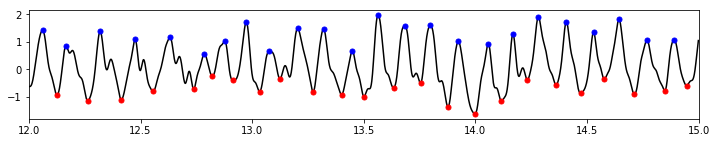

In [4]:
tlim = (12, 15)
tidx = np.logical_and(t>=tlim[0], t<tlim[1])
tidxPs = Ps[np.logical_and(Ps>tlim[0]*Fs, Ps<tlim[1]*Fs)]
tidxTs = Ts[np.logical_and(Ts>tlim[0]*Fs, Ts<tlim[1]*Fs)]

plt.figure(figsize=(12, 2))
plt.plot(t[tidx], signal_low[tidx], 'k')
plt.plot(t[tidxPs], signal_low[tidxPs], 'b.', ms=10)
plt.plot(t[tidxTs], signal_low[tidxTs], 'r.', ms=10)
plt.xlim(tlim)

# 2. Localize rise and decay midpoints
In addition to localizing the peaks and troughs of a cycle, we also want to get more information about the rise and decay periods. For instance, these flanks may have deflections if the peaks or troughs are particularly sharp. In order to gauge a dimension of this, we localize midpoints for each of the rise and decay segments. These midpoints are defined as the times at which the voltage crosses halfway between the adjacent peak and trough voltages. If this threshold is crossed multiple times, then the median time is chosen as the flank midpoint. This is not perfect; however, this is rare, and most of these cycles should be removed by burst detection.

In [5]:
from bycycle.cyclepoints import find_zerox
zeroxR, zeroxD = find_zerox(signal_low, Ps, Ts)

(13, 14)

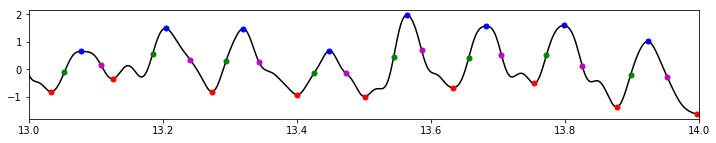

In [6]:
tlim = (13, 14)
tidx = np.logical_and(t>=tlim[0], t<tlim[1])
tidxPs = Ps[np.logical_and(Ps>tlim[0]*Fs, Ps<tlim[1]*Fs)]
tidxTs = Ts[np.logical_and(Ts>tlim[0]*Fs, Ts<tlim[1]*Fs)]
tidxDs = zeroxD[np.logical_and(zeroxD>tlim[0]*Fs, zeroxD<tlim[1]*Fs)]
tidxRs = zeroxR[np.logical_and(zeroxR>tlim[0]*Fs, zeroxR<tlim[1]*Fs)]

plt.figure(figsize=(12, 2))
plt.plot(t[tidx], signal_low[tidx], 'k')
plt.plot(t[tidxPs], signal_low[tidxPs], 'b.', ms=10)
plt.plot(t[tidxTs], signal_low[tidxTs], 'r.', ms=10)
plt.plot(t[tidxDs], signal_low[tidxDs], 'm.', ms=10)
plt.plot(t[tidxRs], signal_low[tidxRs], 'g.', ms=10)
plt.xlim(tlim)

# 3. Compute features of each cycle
After these 4 points of each cycle are localized, we compute some simple statistics for each cycle. The main cycle-by-cycle function returns a table (pandas.DataFrame) in which each entry is a cycle and each column is a property of that cycle (see table below). There are columns to indicate where in the signal the cycle is located, but the four main features are:
1. amplitude (`volt_amp`) - average voltage change of the rise and decay
2. period (`period`) - time between consecutive troughs (or peaks, if default is changed)
3. rise-decay symmetry (`time_rdsym`) - fraction of the period in the rise period
4. peak-trough symmetry (`time_ptsym`) - fraction of the period in the peak period


In [8]:
from bycycle.features import cycle_by_cycle

df = cycle_by_cycle(signal, Fs, f_theta,
                    burst_detection_method='cycles',
                    burst_detection_kwargs=None)

df.head()

/gh/bv/bycycle/bycycle/features.py:104: UserWarning: 
            No burst detection parameters are provided.
            This is very much not recommended.
            Please inspect your data and choose appropriate
            parameters for "burst_detection_kwargs".
            Default burst detection parameters are likely
            not well suited for your desired application.
            
  ''')
/gh/bv/bycycle/bycycle/filt.py:63: UserWarning: 
            No filter length provided. Using default of 3 cycles of the
            low cutoff frequency.
            
  ''')


,band_amp,period,sample_last_trough,sample_next_trough,sample_peak,sample_zerox_decay,sample_zerox_rise,time_decay,time_peak,time_ptsym,...,volt_amp,volt_decay,volt_peak,volt_rise,volt_trough,amp_fraction,amp_consistency,period_consistency,monotonicity,is_burst
0,0.570788,224,519,743,615,663,575,128,88,0.442211,...,2.3595,2.266,1.195,2.453,-1.258,0.423620,NaN,NaN,0.633444,False
1,0.355844,171,743,914,819,882,771,95,111,0.506849,...,1.2980,1.004,0.521,1.592,-1.071,0.002567,0.409295,0.763393,0.584539,False
2,0.686511,142,914,1056,1002,1026,937,54,89,0.618056,...,1.8865,2.197,1.093,1.576,-0.483,0.077022,0.687010,0.830409,0.647907,False
3,0.680391,158,1056,1214,1131,1174,1101,83,73,0.493243,...,2.5945,2.294,1.791,2.895,-1.104,0.643132,0.687010,0.887640,0.604812,False
4,0.654177,178,1214,1392,1273,1331,1229,119,102,0.649682,...,2.4725,2.684,1.758,2.261,-0.503,0.537869,0.842399,0.691011,0.607101,False


# 4. Determine parts of signal in oscillatory burst